# Get PPI data using openEO

The Plant Phenology Index (PPI) is a satellite-based vegetation index designed to monitor vegetation growth cycles (phenology) with improved sensitivity during early spring green-up and late autumn senescence. Unlike traditional indices like NDVI, PPI maintains a linear relationship with green leaf area index (LAI) across the entire growing season.

In this notebook, we will demonstrate how to access and process PPI data using the openEO API in the Copernicus Data Space Ecosystem (CDSE). Two main approaches will be covered: (i) accessing the PPI product and (ii) computing PPI using openEO User-Defined Processes (UDP) on Sentinel-2 data.

All processing is executed in the cloud on the CDSE infrastructure using openEO API, so no local data download or heavy computation is required. Therefore, if you don't yet have an account on CDSE, please register at [https://dataspace.copernicus.eu](https://dataspace.copernicus.eu)


In this notebook, you will learn how to:
* Connect to the CDSE backend
* Directly access the PPI product provided by [European Environment Agency (EEA)](https://www.eea.europa.eu/en/datahub/datahubitem-view/b967dae7-783b-44eb-a3eb-727e3b8fc060)
* Compute PPI on demand using the openEO UDP service 
* Run EO processing workflows entirely in the cloud and download only the final results

Prerequisites
* A CDSE account (register at https://dataspace.copernicus.eu)
* Basic familiarity with Python and Earth Observation data 

## Introduction

Before we jump into the practical steps, let's briefly understand what is openEO and the concepts involved in accessing PPI data.

### What is openEO?

openEO is an open-source standard that simplifies access to and processing of Earth Observation (EO) data.
Instead of downloading and processing large satellite datasets locally, openEO allows users to:
* Access EO data directly where it is stored
* Run scalable processing workflows in the cloud
* Save workflows as User-Defined Processes (UDPs) such as the PPI service for PPI computation
* Reshare and reuse UDPs as services

This enables faster, more reproducible, and easier-to-scale EO data analysis.

### openEO workflows

Before using the openEO service, it is useful to understand the general structure of an openEO workflow.

Most openEO workflows follow the same high-level pattern:
1. Connect to an openEO backend
2. Load collection for a specific spatial and temporal extent
3. Build a processing workflow (also called a *process graph*) using openEO processes
4. Execute the workflow on the backend

For a full introduction to these concepts, please refer to the official openEO *Getting Started* notebook:  
https://github.com/Open-EO/openeo-community-examples/blob/main/python/1.%20GettingStarted/GettingStarted.ipynb


### openEO User-Defined Processes and Services

While building workflows many times from scratch can be tedious, openEO supports the creation of reusable processing chains. 

Such workflows can be encapsulated as **User-Defined Processes (UDPs)** and shared as **services**. These services:
- Hide the complexity of the underlying processing workflow
- Require fewer inputs from the user
- Ensure consistent and reproducible results

The **PPI openEO service** is one such service. It encompasses a comprehensive processing workflow for deriving biophysical vegetation parameters from Sentinel-2 data.

Let's get started by installing the required Python package.

## Installation

The only package required to run this service is the `openeo` Python client, which can be installed via pip:

```

pip install openeo

```

In [1]:
import openeo

Next, let's set up a connection to an openEO backend, in this case the Copernicus Data Space Ecosystem (CDSE). 

You can authenticate using your credentials as shown below.

In [2]:
connection = openeo.connect("openeo.dataspace.copernicus.eu").authenticate_oidc()

Authenticated using refresh token.


### Method 1: Accessing operational PPI product

The first method demonstrates how to load the global PPI product, COPERNICUS_PLANT_PHENOLOGY_INDEX. Let us first identify the available collection for the PPI product. We can do this by listing all available collections and filtering for those related to PPI.

In [3]:
collections = connection.list_collections()

for collection in collections:
    title = collection.get("title", "")
    cid = collection.get("id", "")
    if "PPI" in title or "PPI" in cid:
        print(f"ID: {cid}, Title: {title}")


ID: COPERNICUS_PLANT_PHENOLOGY_INDEX, Title: Seasonal PPI Trajectories, 10-daily, UTM projection


In [4]:
connection.describe_collection("COPERNICUS_PLANT_PHENOLOGY_INDEX")

{'assets': {},
 'cube:dimensions': {'bands': {'type': 'bands', 'values': ['QFLAG', 'PPI']},
  't': {'extent': ['2017-01-01T00:00:00Z', None], 'type': 'temporal'},
  'x': {'axis': 'x',
   'extent': [-62.0760771, 56.138312],
   'reference_system': {'$schema': 'https://proj.org/schemas/v0.2/projjson.schema.json',
    'area': 'World',
    'bbox': {'east_longitude': 180,
     'north_latitude': 90,
     'south_latitude': -90,
     'west_longitude': -180},
    'coordinate_system': {'axis': [{'abbreviation': 'Lat',
       'direction': 'north',
       'name': 'Geodetic latitude',
       'unit': 'degree'},
      {'abbreviation': 'Lon',
       'direction': 'east',
       'name': 'Geodetic longitude',
       'unit': 'degree'}],
     'subtype': 'ellipsoidal'},
    'datum': {'ellipsoid': {'inverse_flattening': 298.257223563,
      'name': 'WGS 84',
      'semi_major_axis': 6378137},
     'name': 'World Geodetic System 1984',
     'type': 'GeodeticReferenceFrame'},
    'id': {'authority': 'OGC', 'code': 'Auto42001', 'version': '1.3'},
    'name': 'AUTO 42001 (Universal Transverse Mercator)',
    'type': 'GeodeticCRS'},
   'step': 10,
   'type': 'spatial'},
  'y': {'axis': 'y',
   'extent': [-21.7894746, 72.0995811],
   'reference_system': {'$schema': 'https://proj.org/schemas/v0.2/projjson.schema.json',
    'area': 'World',
    'bbox': {'east_longitude': 180,
     'north_latitude': 90,
     'south_latitude': -90,
     'west_longitude': -180},
    'coordinate_system': {'axis': [{'abbreviation': 'Lat',
       'direction': 'north',
       'name': 'Geodetic latitude',
       'unit': 'degree'},
      {'abbreviation': 'Lon',
       'direction': 'east',
       'name': 'Geodetic longitude',
       'unit': 'degree'}],
     'subtype': 'ellipsoidal'},
    'datum': {'ellipsoid': {'inverse_flattening': 298.257223563,
      'name': 'WGS 84',
      'semi_major_axis': 6378137},
     'name': 'World Geodetic System 1984',
     'type': 'GeodeticReferenceFrame'},
    'id': {'authority': 'OGC', 'code': 'Auto42001', 'version': '1.3'},
    'name': 'AUTO 42001 (Universal Transverse Mercator)',
    'type': 'GeodeticCRS'},
   'step': 10,
   'type': 'spatial'}},
 'description': '[EXPERIMENTAL] Plant phenology index (PPI) at 10m resolution for EU.',
 'experimental': True,
 'extent': {'spatial': {'bbox': [[-62.0760771,
     -21.7894746,
     56.138312,
     72.0995811]]},
  'temporal': {'interval': [['2017-01-01T00:00:00Z', None]]}},
 'id': 'COPERNICUS_PLANT_PHENOLOGY_INDEX',
 'item_assets': {'PPI': {'description': 'PPI',
   'raster:bands': [{'bits_per_sample': 16,
     'data_type': 'uint16',
     'name': 'PPI',
     'offset': 0,
     'sampling': 'area',
     'scale': 0.0001,
     'spatial_resolution': 10}],
   'roles': ['data'],
   'title': 'PPI',
   'type': 'image/tiff; application=geotiff'},
  'QFLAG': {'description': 'QFLAG',
   'raster:bands': [{'bits_per_sample': 8,
     'data_type': 'uint8',
     'name': 'QFLAG',
     'sampling': 'area',
     'spatial_resolution': 10}],
   'roles': ['data'],
   'title': 'QFLAG',
   'type': 'image/tiff; application=geotiff'}},
 'keywords': ['PPI',
  'index',
  'land',
  'vegetation',
  'plant',
  'phenology',
  'growing season',
  'productivity',
  'sentinel'],
 'license': 'proprietary',
 'links': [{'href': 'https://stac.openeo.vito.be/collections/copernicus_r_utm-wgs84_10_m_hrvpp-st_p_2017-now_v01/aggregate',
   'rel': 'aggregate',
   'type': 'application/json'},
  {'href': 'https://stac.openeo.vito.be/collections/copernicus_r_utm-wgs84_10_m_hrvpp-st_p_2017-now_v01/aggregations',
   'rel': 'aggregations',
   'type': 'application/json'},
  {'href': 'https://stac.openeo.vito.be/collections/copernicus_r_utm-wgs84_10_m_hrvpp-st_p_2017-now_v01/items',
   'rel': 'items',
   'type': 'application/geo+json'},
  {'href': 'https://stac.openeo.vito.be/',
   'rel': 'parent',
   'type': 'application/json'},
  {'href': 'https://stac.openeo.vito.be/collections/copernicus_r_utm-wgs84_10_m_hrvpp-st_p_2017-now_v01/queryables',
   'rel': 'queryables

An experimental PPI product is available to access and process via openEO in the Copernicus Data Space Ecosystem (CDSE). This product is provided by the European Environment Agency (EEA) at 10m resolution.

In the following sections, we will demonstrate how to access this PPI product using openEO for a specific area and time range.

In [5]:
ppi_10m = connection.load_collection(
    "COPERNICUS_PLANT_PHENOLOGY_INDEX",
    temporal_extent=["2019-01-01", "2019-02-01"],
    spatial_extent={"west": 5.215759, "south": 51.160296, "east": 5.405960, "north": 51.244815},
    bands=["PPI"],
)

As openEO follows a lazy execution model, no processing is done yet. We have just defined the data we want to work with. As a user you can now build more complex processing workflows using openEO processes. Advance usecases using openEO for EO data processing can be found in the [openEO community examples repository](https://github.com/Open-EO/openeo-community-examples/tree/main/python)

In this example, we will keep it simple and just create a job to download the data. For more information on openEO batch jobs, please refer to the [openEO documentation](https://open-eo.github.io/openeo-python-client/batch_jobs.html).

In [6]:
job = ppi_10m.create_job(out_format="GTiff", title="PPI_10m_Job")
job.start_and_wait()

0:00:00 Job 'j-26012808482043d7886d22babf2e78fb': send 'start'
0:00:14 Job 'j-26012808482043d7886d22babf2e78fb': created (progress 0%)
0:00:19 Job 'j-26012808482043d7886d22babf2e78fb': created (progress 0%)
0:00:26 Job 'j-26012808482043d7886d22babf2e78fb': created (progress 0%)
0:00:34 Job 'j-26012808482043d7886d22babf2e78fb': created (progress 0%)
0:00:43 Job 'j-26012808482043d7886d22babf2e78fb': created (progress 0%)
0:00:56 Job 'j-26012808482043d7886d22babf2e78fb': running (progress N/A)
0:01:11 Job 'j-26012808482043d7886d22babf2e78fb': running (progress N/A)
0:01:30 Job 'j-26012808482043d7886d22babf2e78fb': running (progress N/A)
0:01:55 Job 'j-26012808482043d7886d22babf2e78fb': running (progress N/A)
0:02:25 Job 'j-26012808482043d7886d22babf2e78fb': finished (progress 100%)


<BatchJob job_id='j-26012808482043d7886d22babf2e78fb'>

Once a batch job is finished you can get a handle to the results (which can be a single file or multiple files) and download them to a local directory.

In [7]:
results = job.get_results()
results.download_files("data/ppi_10m")

[PosixPath('data/ppi_10m/openEO_2019-01-01Z.tif'),
 PosixPath('data/ppi_10m/openEO_2019-01-11Z.tif'),
 PosixPath('data/ppi_10m/openEO_2019-01-21Z.tif'),
 PosixPath('data/ppi_10m/job-results.json')]

### Method 2: On-demand PPI computation with openEO UDP

The second method presented in this notebook is the on-demand computation of PPI using the openEO service. 

As mentioned earlier, the openEO service is a reusable processing component (called a User-Defined Process, or UDP).It is hosted in[APEx Algorithm Catalogue](https://algorithm-catalogue.apex.esa.int) for on-demand PPI computation. 


To compute a specific product from the openEO service, we call the process through an active openEO connection, which returns a datacube containing the requested data. In this case, it requires:
- `temporal_extent`: The time range for which the data is requested.
- `geometry`: The area of interest. It can be a feature collection or bounding box coordinates.

This openEO process calculates PPI using Sentinel-2 data and MDVI reference collections.

The namespace parameter references a publicly accessible JSON file that defines the process graph for the PPI algorithm. This graph summarizes all the steps the service performs on Sentinel-2 data to derive the requested parameter.



In [12]:
aoi = {
            "type": "Polygon",
            "coordinates": [
              [
                [
                  4.22,
                  51.16
                ],
                [
                  4.377856,
                  51.16
                ],
                [
                  4.377856,
                  51.26
                ],
                [
                  4.22,
                  51.26
                ],
                [
                  4.22,
                  51.16
                ]
              ]
            ]
          }

# Create a processing graph from the PPI process using an active openEO connection
ppi_cube = connection.datacube_from_process(
        "ppi", 
        namespace = "https://raw.githubusercontent.com/ESA-APEx/apex_algorithms/refs/heads/main/algorithm_catalog/vito/ppi/openeo_udp/ppi.json",
        temporal_extent = ["2020-05-06", "2020-05-30"],
        geometry= aoi
        )

In [13]:
job = ppi_cube.create_job(out_format="GTiff", title="PPI_Job")
job.start_and_wait()

0:00:00 Job 'j-260128091328427985fdc1b3e36f3934': send 'start'
0:00:15 Job 'j-260128091328427985fdc1b3e36f3934': created (progress 0%)
0:00:20 Job 'j-260128091328427985fdc1b3e36f3934': created (progress 0%)
0:00:26 Job 'j-260128091328427985fdc1b3e36f3934': created (progress 0%)
0:00:34 Job 'j-260128091328427985fdc1b3e36f3934': created (progress 0%)
0:00:44 Job 'j-260128091328427985fdc1b3e36f3934': running (progress N/A)
0:00:57 Job 'j-260128091328427985fdc1b3e36f3934': running (progress N/A)
0:01:12 Job 'j-260128091328427985fdc1b3e36f3934': running (progress N/A)
0:01:32 Job 'j-260128091328427985fdc1b3e36f3934': running (progress N/A)
0:01:56 Job 'j-260128091328427985fdc1b3e36f3934': running (progress N/A)
0:02:26 Job 'j-260128091328427985fdc1b3e36f3934': running (progress N/A)
0:03:04 Job 'j-260128091328427985fdc1b3e36f3934': finished (progress 100%)


<BatchJob job_id='j-260128091328427985fdc1b3e36f3934'>

In [14]:
results = job.get_results()
results.download_files("data/ppi_udp")

[PosixPath('data/ppi_udp/openEO_2020-05-07Z.tif'),
 PosixPath('data/ppi_udp/openEO_2020-05-12Z.tif'),
 PosixPath('data/ppi_udp/openEO_2020-05-15Z.tif'),
 PosixPath('data/ppi_udp/openEO_2020-05-17Z.tif'),
 PosixPath('data/ppi_udp/openEO_2020-05-20Z.tif'),
 PosixPath('data/ppi_udp/openEO_2020-05-22Z.tif'),
 PosixPath('data/ppi_udp/openEO_2020-05-25Z.tif'),
 PosixPath('data/ppi_udp/openEO_2020-05-27Z.tif'),
 PosixPath('data/ppi_udp/job-results.json')]

## Quick visualization

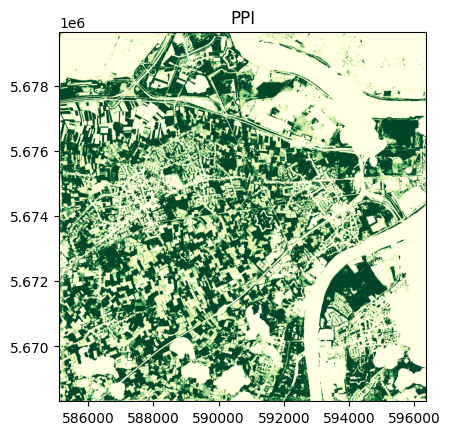

In [22]:
import rasterio
import rasterio.plot
import matplotlib.pyplot as plt

tif_file = "data/ppi_udp/openEO_2020-05-25Z.tif"

with rasterio.open(tif_file) as src:
    data = src.read(1)
    extent = rasterio.plot.plotting_extent(src)

plt.imshow(data, cmap="YlGn", extent=extent)
plt.title("PPI")
plt.show()


Therefore, by using any of these approaches either direct product access or on-demand PPI computation, user can obtain PPI data for their area and time of interest. Together, these workflows illustrate how openEO can be used as a unified interface supporting reproducible, scalable land and climate monitoring applications.